# Phase 3 Weighted Bagging

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import os
import re
import csv
import codecs
import gensim
import itertools
import numpy as np
import pandas as pd
import operator
import sys

from nltk import ngrams
from collections import Counter
from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from iwillwin.trainer.supervised_trainer import KerasModelTrainer
from iwillwin.data_utils.data_helpers import DataTransformer, DataLoader
from iwillwin.config import dataset_config
from iwillwin.data_utils.feature_engineering import FeatureCreator

from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize

import seaborn as sns
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
import re
import csv
import codecs
import numpy as np
import pandas as pd
import operator
from os import listdir
from os.path import isfile, join

########################################
## import packages
########################################
import os
import re
import csv
import codecs
import numpy as np
np.random.seed(1337)

import pandas as pd
import operator
import sys

from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from iwillwin.trainer.supervised_trainer import KerasModelTrainer
from iwillwin.data_utils.data_helpers import DataTransformer, DataLoader
from iwillwin.config import dataset_config
from keras.utils import to_categorical

C:\Users\zake7\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zake7\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
NB_WORDS, MAX_SEQUENCE_LENGTH = 50000, 50
data_transformer = DataTransformer(max_num_words=NB_WORDS, max_sequence_length=MAX_SEQUENCE_LENGTH, char_level=False,
                                   normalization=True, features_processed=True)
trains_nns, tests_nns, labels = data_transformer.prepare_data(dual=False)
print("Number of unique words", len(data_transformer.tokenizer.index_docs))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zake7\AppData\Local\Temp\jieba.cache
Loading model cost 0.466 seconds.
Prefix dict has been built succesfully.


[DataHelper] Apply normalization on value-type columns


C:\Users\zake7\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Doing preprocessing...
Transforming words to indices...
Shape of data tensor: (320552, 50) (320552, 50)
Shape of label tensor: (320552,)
Preprocessed.
Number of unique words 83265


In [3]:
trains_meta = trains_nns[2]
tests_meta = tests_nns[2]

In [4]:
train_df = pd.read_csv('../data/dataset/train.csv')
test_df = pd.read_csv('../data/dataset/test.csv')

In [5]:
rumor_words = ['辟谣', '谣言', '勿传', '假的']

def is_rumor(text):
    if type(text) != str:
        print(text, type(text))
        return 0
    for rumor_word in rumor_words:
        if rumor_word in text:
            return 1
    return 0

def has_split_symbol(text):
    if type(text) != str:
        return 0
    if '|' in text:
        return 1
    return 0

for df in [train_df, test_df]:
    df['has_|'] = df['title2_zh'].apply(has_split_symbol)
    df['has_rumor_words'] = df['title2_zh'].apply(is_rumor)

nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>


In [6]:
train_has_rumor = train_df.has_rumor_words.values
test_has_rumor = test_df.has_rumor_words.values

trick_trains_features = np.concatenate((trains_nns[2], train_has_rumor.reshape((-1, 1))), axis=1)
trick_tests_features = np.concatenate((tests_nns[2], test_has_rumor.reshape((-1, 1))), axis=1)

In [7]:
oof_file_names = sorted([f for f in listdir('../data/oofs/') if isfile(join('../data/oofs/', f)) and f != '.gitkeep'])
preds_file_names = [name.replace('-Train', '') for name in oof_file_names]

oofs = []
preds = []
for name in oof_file_names:
    oofs.append(pd.read_csv('../data/oofs/' + name))
for name in preds_file_names:
    preds.append(pd.read_csv('../data/output/' + name))    

In [8]:
for i, name in enumerate(oof_file_names):
    print(i, name)
    
trains = pd.DataFrame()
tests = pd.DataFrame()

for i in range(len(oof_file_names)):
    for label_type in ['agreed', 'disagreed', 'unrelated']:
        trains['oofs_{}_{}'.format(i, label_type)] = oofs[i][label_type].values
        tests['oofs_pred{}_{}'.format(i, label_type)] = preds[i][label_type].values

0 3Embedding-3LayersDenseCNN42-NoDrop-NoClassWeighted-NoEM-Train-L0.809633-NB5000.csv
1 3Embedding-3LayersDenseRNN42-Drop01-NoMeta-NoClassWeighted-WithEM-Train-L0.816583-NB5000.csv
2 3Embedding-ESIM-Drop01-NoMeta-NoClassWeighted-NoEM-Train-L0.833565-NB5000.csv
3 WordSGNS-DenseCNN5Layers-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.838202-NB100000.csv
4 WordSGNS-ESIM-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L1.104962-NB100000.csv
5 WordTC-DenseCNN5Layers-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.8440-NB100000.csv
6 WordTC-DenseRNN-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.854586-NB100000.csv
7 WordTC-ESIM-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.374334-NB100000.csv
8 WordTC-Gated4GWindows-NoMeta-3P-NoEM-NoClassWeighted-3Layers-withEM-Train-L0.836860-NB100000.csv


In [14]:
oof_file_names

['3Embedding-3LayersDenseCNN42-NoDrop-NoClassWeighted-NoEM-Train-L0.809633-NB5000.csv',
 '3Embedding-3LayersDenseRNN42-Drop01-NoMeta-NoClassWeighted-WithEM-Train-L0.816583-NB5000.csv',
 '3Embedding-ESIM-Drop01-NoMeta-NoClassWeighted-NoEM-Train-L0.833565-NB5000.csv',
 'WordSGNS-DenseCNN5Layers-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.838202-NB100000.csv',
 'WordSGNS-ESIM-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L1.104962-NB100000.csv',
 'WordTC-DenseCNN5Layers-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.8440-NB100000.csv',
 'WordTC-DenseRNN-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.854586-NB100000.csv',
 'WordTC-ESIM-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.374334-NB100000.csv',
 'WordTC-Gated4GWindows-NoMeta-3P-NoEM-NoClassWeighted-3Layers-withEM-Train-L0.836860-NB100000.csv']

In [10]:
unrelated = pd.DataFrame()
agreeds = pd.DataFrame()
disagreeds = pd.DataFrame()

#check_oofs = True
check_oofs = False


if check_oofs:
    for i, oof in enumerate(oofs):
        agreeds['oofs_agreed_{}'.format(i)] = oofs[i]['agreed'].values
        unrelated['oofs_unrelated_{}'.format(i)] = oofs[i]['unrelated'].values
        disagreeds['oofs_disagreeds_{}'.format(i)] = oofs[i]['disagreed'].values
else:
    for i, oof in enumerate(oofs):
        agreeds['oofs_agreed_{}'.format(i)] = preds[i]['agreed'].values
        unrelated['oofs_unrelated_{}'.format(i)] = preds[i]['unrelated'].values
        disagreeds['oofs_disagreeds_{}'.format(i)] = preds[i]['disagreed'].values  

In [11]:
agreeds.corr()

,oofs_agreed_0,oofs_agreed_1,oofs_agreed_2,oofs_agreed_3,oofs_agreed_4,oofs_agreed_5,oofs_agreed_6,oofs_agreed_7,oofs_agreed_8
oofs_agreed_0,1.000000,0.982310,0.976632,0.959797,0.956807,0.961449,0.961597,0.959404,0.962629
oofs_agreed_1,0.982310,1.000000,0.982479,0.958966,0.957473,0.961494,0.961780,0.961639,0.961288
oofs_agreed_2,0.976632,0.982479,1.000000,0.955476,0.959167,0.957512,0.961050,0.963775,0.956841
oofs_agreed_3,0.959797,0.958966,0.955476,1.000000,0.982100,0.977313,0.970090,0.972992,0.973543
oofs_agreed_4,0.956807,0.957473,0.959167,0.982100,1.000000,0.971693,0.972289,0.979278,0.968705
oofs_agreed_5,0.961449,0.961494,0.957512,0.977313,0.971693,1.000000,0.981701,0.981716,0.982047
oofs_agreed_6,0.961597,0.961780,0.961050,0.970090,0.972289,0.981701,1.000000,0.983917,0.982819
oofs_agreed_7,0.959404,0.961639,0.963775,0.972992,0.979278,0.981716,0.983917,1.000000,0.978351
oofs_agreed_8,0.962629,0.961288,0.956841,0.973543,0.968705,0.982047,0.982819,0.978351,1.000000


In [12]:
disagreeds.corr()

,oofs_disagreeds_0,oofs_disagreeds_1,oofs_disagreeds_2,oofs_disagreeds_3,oofs_disagreeds_4,oofs_disagreeds_5,oofs_disagreeds_6,oofs_disagreeds_7,oofs_disagreeds_8
oofs_disagreeds_0,1.000000,0.954897,0.951416,0.912412,0.913741,0.912573,0.916230,0.912694,0.908535
oofs_disagreeds_1,0.954897,1.000000,0.964977,0.920113,0.918646,0.920680,0.921862,0.920311,0.911443
oofs_disagreeds_2,0.951416,0.964977,1.000000,0.919030,0.925045,0.915579,0.923305,0.926555,0.913171
oofs_disagreeds_3,0.912412,0.920113,0.919030,1.000000,0.967334,0.956456,0.945988,0.954167,0.943892
oofs_disagreeds_4,0.913741,0.918646,0.925045,0.967334,1.000000,0.946770,0.944932,0.961943,0.939010
oofs_disagreeds_5,0.912573,0.920680,0.915579,0.956456,0.946770,1.000000,0.965450,0.960278,0.955281
oofs_disagreeds_6,0.916230,0.921862,0.923305,0.945988,0.944932,0.965450,1.000000,0.963620,0.958197
oofs_disagreeds_7,0.912694,0.920311,0.926555,0.954167,0.961943,0.960278,0.963620,1.000000,0.954127
oofs_disagreeds_8,0.908535,0.911443,0.913171,0.943892,0.939010,0.955281,0.958197,0.954127,1.000000


In [13]:
unrelated.corr()

,oofs_unrelated_0,oofs_unrelated_1,oofs_unrelated_2,oofs_unrelated_3,oofs_unrelated_4,oofs_unrelated_5,oofs_unrelated_6,oofs_unrelated_7,oofs_unrelated_8
oofs_unrelated_0,1.000000,0.978855,0.972572,0.952930,0.949506,0.954771,0.955016,0.952586,0.955786
oofs_unrelated_1,0.978855,1.000000,0.979417,0.952496,0.950368,0.955304,0.955510,0.955456,0.954800
oofs_unrelated_2,0.972572,0.979417,1.000000,0.948158,0.952290,0.950251,0.954365,0.957542,0.949502
oofs_unrelated_3,0.952930,0.952496,0.948158,1.000000,0.979002,0.973876,0.965568,0.969264,0.969451
oofs_unrelated_4,0.949506,0.950368,0.952290,0.979002,1.000000,0.967039,0.967506,0.975886,0.963249
oofs_unrelated_5,0.954771,0.955304,0.950251,0.973876,0.967039,1.000000,0.978773,0.978637,0.978786
oofs_unrelated_6,0.955016,0.955510,0.954365,0.965568,0.967506,0.978773,1.000000,0.981089,0.979624
oofs_unrelated_7,0.952586,0.955456,0.957542,0.969264,0.975886,0.978637,0.981089,1.000000,0.974969
oofs_unrelated_8,0.955786,0.954800,0.949502,0.969451,0.963249,0.978786,0.979624,0.974969,1.000000


# Prepare Different Inputs

In [22]:
# word level
ensemble_trains = trains.values[:, :-9]
ensemble_tests = tests.values[:, :-9]

In [27]:
# Only use oofs
#ensemble_trains = trains.values
#ensemble_tests = tests.values

In [16]:
# Use oof and meta features
#ensemble_trains = np.concatenate((trains.values, trains_meta), axis=1)
#ensemble_tests = np.concatenate((tests.values, tests_meta), axis=1)

In [21]:
# use oofs and meta-features
#ensemble_trains = np.concatenate((trains.values, trick_trains_features), axis=1)
#ensemble_tests = np.concatenate((tests.values, trick_tests_features), axis=1)

In [41]:
#ensemble_trains = trick_trains_features
#ensemble_tests = trick_tests_features

# LGBM

In [23]:
from sklearn import metrics

In [24]:
def fit_every_feature_model(feature_data, label, feature_test_data, fold_count=3, predict=True):
    predictions = np.zeros(shape=[len(feature_test_data), 3])
    fold_size = len(feature_data) // fold_count
    oofs = []
    
    log_loss = 0
    for fold_id in range(fold_count):
        print("Fold : ", fold_id)
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        if fold_id == fold_count - 1:
            fold_end = len(feature_data)
                
        train_x = np.concatenate([feature_data[:fold_start], feature_data[fold_end:]])
        train_y = np.concatenate([label[:fold_start], label[fold_end:]])

        val_x = feature_data[fold_start:fold_end]
        val_y = label[fold_start:fold_end]
        
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_val = lgb.Dataset(val_x, val_y)
        
        lgb_params = {
            'boosting_type' : 'gbdt',
            'objective' : 'multiclass',
            'num_class':3,
            'metric' : {'multi_logloss',},
            'learning_rate' : 0.01,
            'feature_fraction' : 0.8,
            'bagging_fraction': 0.9,
            'bagging_freq': 1,
            'num_leaves' : 4,
            'max_depth': 16,
            'random_state': 42,
            'nthread': 8,
        }
        
        lgbm_model = lgb.train(lgb_params, lgb_train, num_boost_round=100000, valid_sets=[lgb_train, lgb_val],
                        early_stopping_rounds=1000, verbose_eval=100)
        
        lgb.plot_importance(lgbm_model)
        plt.show()
        if predict:
            prediction = lgbm_model.predict(feature_test_data, num_iteration=lgbm_model.best_iteration)
            oof_prediction = lgbm_model.predict(val_x, num_iteration=lgbm_model.best_iteration)
            score = metrics.log_loss(val_y, oof_prediction)
            print("Fold", fold_id, "log loss", score, "in", lgbm_model.best_iteration)
            log_loss += score
            oofs.append(oof_prediction)
            predictions += prediction
            del lgbm_model
    predictions /= fold_count   
    print("Training  Finish")

    return predictions, log_loss / fold_count, oofs

Fold :  0
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.533625	valid_1's multi_logloss: 0.536458
[200]	training's multi_logloss: 0.366426	valid_1's multi_logloss: 0.371247
[300]	training's multi_logloss: 0.30671	valid_1's multi_logloss: 0.312181
[400]	training's multi_logloss: 0.282843	valid_1's multi_logloss: 0.288617
[500]	training's multi_logloss: 0.272383	valid_1's multi_logloss: 0.278319
[600]	training's multi_logloss: 0.267357	valid_1's multi_logloss: 0.273385
[700]	training's multi_logloss: 0.26471	valid_1's multi_logloss: 0.270879
[800]	training's multi_logloss: 0.263188	valid_1's multi_logloss: 0.269527
[900]	training's multi_logloss: 0.262247	valid_1's multi_logloss: 0.268759
[1000]	training's multi_logloss: 0.261631	valid_1's multi_logloss: 0.268298
[1100]	training's multi_logloss: 0.261206	valid_1's multi_logloss: 0.268028
[1200]	training's multi_logloss: 0.260909	valid_1's multi_logloss: 0.267859
[1300]	training's multi_l

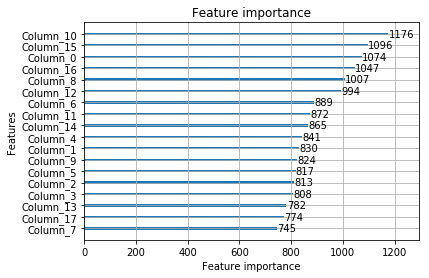

Fold 0 log loss 0.2675507081690603 in 1806
Fold :  1
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.535975	valid_1's multi_logloss: 0.515325
[200]	training's multi_logloss: 0.369405	valid_1's multi_logloss: 0.343021
[300]	training's multi_logloss: 0.309893	valid_1's multi_logloss: 0.282651
[400]	training's multi_logloss: 0.286088	valid_1's multi_logloss: 0.258761
[500]	training's multi_logloss: 0.275627	valid_1's multi_logloss: 0.248412
[600]	training's multi_logloss: 0.270579	valid_1's multi_logloss: 0.243614
[700]	training's multi_logloss: 0.267913	valid_1's multi_logloss: 0.241232
[800]	training's multi_logloss: 0.266385	valid_1's multi_logloss: 0.239972
[900]	training's multi_logloss: 0.265444	valid_1's multi_logloss: 0.239266
[1000]	training's multi_logloss: 0.264839	valid_1's multi_logloss: 0.238832
[1100]	training's multi_logloss: 0.264422	valid_1's multi_logloss: 0.238558
[1200]	training's multi_logloss: 0.264125	valid_1's mult

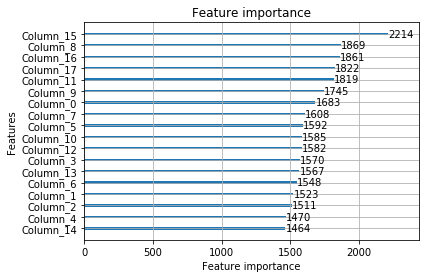

Fold 1 log loss 0.23790060514533928 in 3337
Fold :  2
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.533918	valid_1's multi_logloss: 0.534443
[200]	training's multi_logloss: 0.366865	valid_1's multi_logloss: 0.367371
[300]	training's multi_logloss: 0.307203	valid_1's multi_logloss: 0.30743
[400]	training's multi_logloss: 0.28338	valid_1's multi_logloss: 0.2836
[500]	training's multi_logloss: 0.272953	valid_1's multi_logloss: 0.27301
[600]	training's multi_logloss: 0.267945	valid_1's multi_logloss: 0.2679
[700]	training's multi_logloss: 0.265298	valid_1's multi_logloss: 0.265241
[800]	training's multi_logloss: 0.263783	valid_1's multi_logloss: 0.263792
[900]	training's multi_logloss: 0.262844	valid_1's multi_logloss: 0.262962
[1000]	training's multi_logloss: 0.26223	valid_1's multi_logloss: 0.262461
[1100]	training's multi_logloss: 0.26181	valid_1's multi_logloss: 0.262144
[1200]	training's multi_logloss: 0.261503	valid_1's multi_loglos

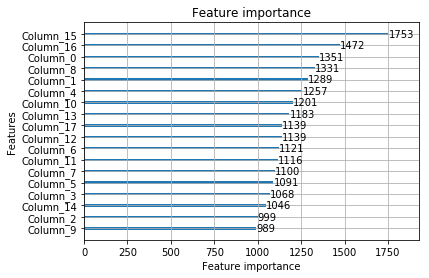

Fold 2 log loss 0.26169731449645584 in 2405
Fold :  3
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.532914	valid_1's multi_logloss: 0.542419
[200]	training's multi_logloss: 0.365586	valid_1's multi_logloss: 0.378324
[300]	training's multi_logloss: 0.305851	valid_1's multi_logloss: 0.3196
[400]	training's multi_logloss: 0.282004	valid_1's multi_logloss: 0.29591
[500]	training's multi_logloss: 0.271559	valid_1's multi_logloss: 0.285432
[600]	training's multi_logloss: 0.266544	valid_1's multi_logloss: 0.280403
[700]	training's multi_logloss: 0.263901	valid_1's multi_logloss: 0.27776
[800]	training's multi_logloss: 0.262391	valid_1's multi_logloss: 0.276345
[900]	training's multi_logloss: 0.261452	valid_1's multi_logloss: 0.275547
[1000]	training's multi_logloss: 0.260839	valid_1's multi_logloss: 0.275096
[1100]	training's multi_logloss: 0.260413	valid_1's multi_logloss: 0.274825
[1200]	training's multi_logloss: 0.260106	valid_1's multi_l

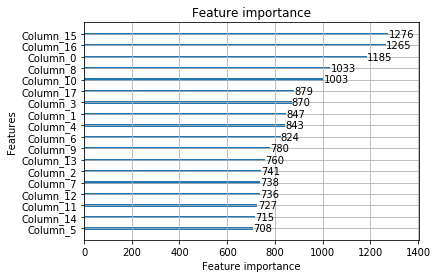

Fold 3 log loss 0.274417589877202 in 1770
Fold :  4
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.534982	valid_1's multi_logloss: 0.526302
[200]	training's multi_logloss: 0.368161	valid_1's multi_logloss: 0.356563
[300]	training's multi_logloss: 0.308529	valid_1's multi_logloss: 0.295882
[400]	training's multi_logloss: 0.284675	valid_1's multi_logloss: 0.27179
[500]	training's multi_logloss: 0.274202	valid_1's multi_logloss: 0.261417
[600]	training's multi_logloss: 0.269166	valid_1's multi_logloss: 0.256502
[700]	training's multi_logloss: 0.266508	valid_1's multi_logloss: 0.253996
[800]	training's multi_logloss: 0.264979	valid_1's multi_logloss: 0.252615
[900]	training's multi_logloss: 0.264034	valid_1's multi_logloss: 0.251839
[1000]	training's multi_logloss: 0.263416	valid_1's multi_logloss: 0.251392
[1100]	training's multi_logloss: 0.262992	valid_1's multi_logloss: 0.251119
[1200]	training's multi_logloss: 0.262683	valid_1's multi_

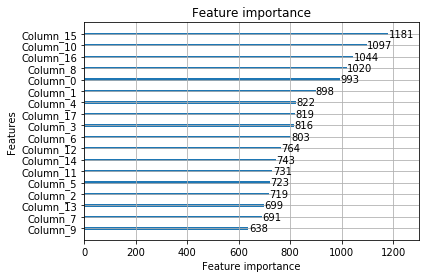

Fold 4 log loss 0.25073535394617447 in 1689
Fold :  5
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.533078	valid_1's multi_logloss: 0.540784
[200]	training's multi_logloss: 0.365863	valid_1's multi_logloss: 0.375397
[300]	training's multi_logloss: 0.306173	valid_1's multi_logloss: 0.316198
[400]	training's multi_logloss: 0.282338	valid_1's multi_logloss: 0.292659
[500]	training's multi_logloss: 0.271897	valid_1's multi_logloss: 0.282353
[600]	training's multi_logloss: 0.266873	valid_1's multi_logloss: 0.277437
[700]	training's multi_logloss: 0.264227	valid_1's multi_logloss: 0.274907
[800]	training's multi_logloss: 0.262706	valid_1's multi_logloss: 0.273507
[900]	training's multi_logloss: 0.261762	valid_1's multi_logloss: 0.272706
[1000]	training's multi_logloss: 0.261146	valid_1's multi_logloss: 0.272249
[1100]	training's multi_logloss: 0.260721	valid_1's multi_logloss: 0.271978
[1200]	training's multi_logloss: 0.260418	valid_1's mul

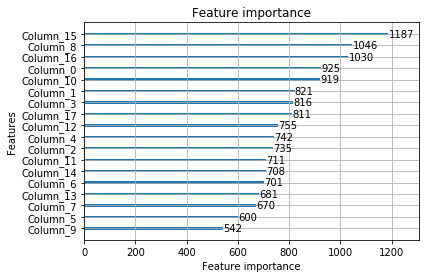

Fold 5 log loss 0.27165172868094783 in 1600
Fold :  6
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.53128	valid_1's multi_logloss: 0.552849
[200]	training's multi_logloss: 0.36362	valid_1's multi_logloss: 0.392816
[300]	training's multi_logloss: 0.303852	valid_1's multi_logloss: 0.336454
[400]	training's multi_logloss: 0.280031	valid_1's multi_logloss: 0.313812
[500]	training's multi_logloss: 0.269603	valid_1's multi_logloss: 0.303716
[600]	training's multi_logloss: 0.264599	valid_1's multi_logloss: 0.298859
[700]	training's multi_logloss: 0.261976	valid_1's multi_logloss: 0.296278
[800]	training's multi_logloss: 0.260477	valid_1's multi_logloss: 0.294812
[900]	training's multi_logloss: 0.259554	valid_1's multi_logloss: 0.293959
[1000]	training's multi_logloss: 0.258954	valid_1's multi_logloss: 0.29346
[1100]	training's multi_logloss: 0.258546	valid_1's multi_logloss: 0.293156
[1200]	training's multi_logloss: 0.258253	valid_1's multi_

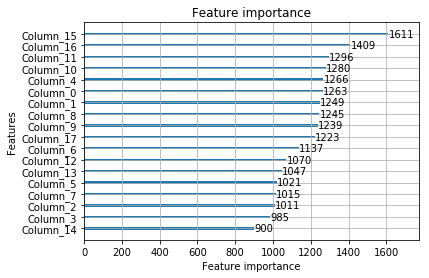

Fold 6 log loss 0.29256034268764847 in 2363
Fold :  7
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.533759	valid_1's multi_logloss: 0.535758
[200]	training's multi_logloss: 0.366682	valid_1's multi_logloss: 0.368803
[300]	training's multi_logloss: 0.307068	valid_1's multi_logloss: 0.308751
[400]	training's multi_logloss: 0.283257	valid_1's multi_logloss: 0.28471
[500]	training's multi_logloss: 0.272809	valid_1's multi_logloss: 0.274143
[600]	training's multi_logloss: 0.267793	valid_1's multi_logloss: 0.269107
[700]	training's multi_logloss: 0.265141	valid_1's multi_logloss: 0.266536
[800]	training's multi_logloss: 0.263605	valid_1's multi_logloss: 0.265144
[900]	training's multi_logloss: 0.262654	valid_1's multi_logloss: 0.264366
[1000]	training's multi_logloss: 0.262036	valid_1's multi_logloss: 0.263916
[1100]	training's multi_logloss: 0.261609	valid_1's multi_logloss: 0.263652
[1200]	training's multi_logloss: 0.261305	valid_1's mult

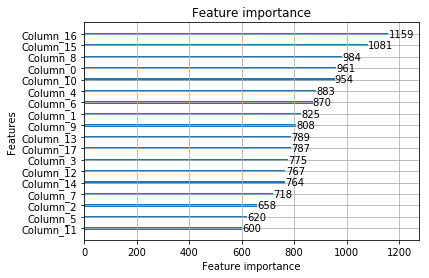

Fold 7 log loss 0.263345294966396 in 1667
Fold :  8
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.533883	valid_1's multi_logloss: 0.535667
[200]	training's multi_logloss: 0.366833	valid_1's multi_logloss: 0.368266
[300]	training's multi_logloss: 0.307135	valid_1's multi_logloss: 0.308266
[400]	training's multi_logloss: 0.283279	valid_1's multi_logloss: 0.28444
[500]	training's multi_logloss: 0.272811	valid_1's multi_logloss: 0.27416
[600]	training's multi_logloss: 0.267776	valid_1's multi_logloss: 0.269307
[700]	training's multi_logloss: 0.265121	valid_1's multi_logloss: 0.266833
[800]	training's multi_logloss: 0.263613	valid_1's multi_logloss: 0.265491
[900]	training's multi_logloss: 0.26268	valid_1's multi_logloss: 0.264756
[1000]	training's multi_logloss: 0.262078	valid_1's multi_logloss: 0.264348
[1100]	training's multi_logloss: 0.261664	valid_1's multi_logloss: 0.264123
[1200]	training's multi_logloss: 0.261364	valid_1's multi_lo

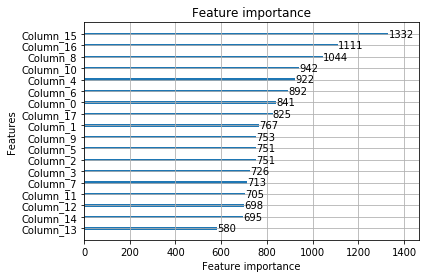

Fold 8 log loss 0.26380198476092676 in 1672
Fold :  9
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.534809	valid_1's multi_logloss: 0.52501
[200]	training's multi_logloss: 0.368056	valid_1's multi_logloss: 0.355506
[300]	training's multi_logloss: 0.308497	valid_1's multi_logloss: 0.295423
[400]	training's multi_logloss: 0.284646	valid_1's multi_logloss: 0.271715
[500]	training's multi_logloss: 0.274176	valid_1's multi_logloss: 0.261519
[600]	training's multi_logloss: 0.269127	valid_1's multi_logloss: 0.256815
[700]	training's multi_logloss: 0.266464	valid_1's multi_logloss: 0.254484
[800]	training's multi_logloss: 0.264926	valid_1's multi_logloss: 0.253234
[900]	training's multi_logloss: 0.263963	valid_1's multi_logloss: 0.252541
[1000]	training's multi_logloss: 0.263336	valid_1's multi_logloss: 0.252148
[1100]	training's multi_logloss: 0.262906	valid_1's multi_logloss: 0.251921
[1200]	training's multi_logloss: 0.262597	valid_1's mult

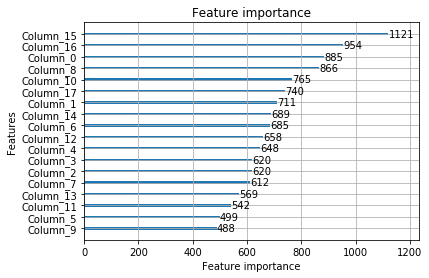

Fold 9 log loss 0.25168880960142886 in 1408
Training  Finish


In [25]:
pred, log_loss, oofs = fit_every_feature_model(ensemble_trains, labels, ensemble_tests, fold_count=10)

In [26]:
print("Word level log_loss", log_loss)

Word level log_loss 0.26353497323315794


In [27]:
oofs = np.concatenate(oofs)
oofs.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
def np_weighted_accuracy(y_true, y_pred):
    weight = np.array([[1/16, 1/15, 1/5]])
    norm = [(1/16) + (1/15) + (1/5)]
    weight_mask = weight * y_true
    weight_mask = np.max(weight_mask, axis=-1)
    norms = np.sum(weight_mask)
    
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    
    res = ((y_true == y_pred) * weight_mask).sum() / norms
    return res

In [29]:
score = np_weighted_accuracy(to_categorical(labels), oofs)

In [30]:
print("score", score)
oofs_dir = "../data/ensemble/oofs/"
output_dir = "../data/ensemble/preds/"
onehot_pred_dir = "../data/ensemble/nn_one_hot/"

model_submit_prefix = "LightGBMWordLevel-Ensemble"

oofs_path = oofs_dir + model_submit_prefix
output_path = output_dir + model_submit_prefix
one_hot_pred_path = onehot_pred_dir + "One-Hot" + model_submit_prefix

print("Predicting training results...")
oofs = pd.DataFrame({"unrelated": oofs[:, 0], "agreed": oofs[:, 1], "disagreed": oofs[:, 2]})
submit_path = oofs_path + "-Train-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
oofs.to_csv(submit_path, index=False)

test_predicts = pd.DataFrame({"unrelated": pred[:, 0], "agreed": pred[:, 1], "disagreed": pred[:, 2]})
submit_path = output_path + "-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
test_predicts.to_csv(submit_path, index=False) # 0.3343

print("Predicting labeled testing results...")
ids = pd.read_csv("../data/dataset/test.csv")
pred_labels = test_predicts.idxmax(axis=1)
sub = pd.DataFrame({"Id": ids['id'].values, "Category": pred_labels})
submit_path = one_hot_pred_path + "-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
sub.to_csv(submit_path, index=False)

score 0.8590955485191333
Predicting training results...
Predicting labeled testing results...
